In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import requests
import json

In [2]:
def fetch_data(start, end):
    response = requests.get('https://tie.digitraffic.fi/api/v1/data/tms-data')
    return response.json()
def fetch_stations():
    response = requests.get('https://tie.digitraffic.fi/api/v3/metadata/tms-stations')
    stations = json_normalize(response.json()["features"])
    return stations

def fetch_sensors():
    response = requests.get('https://tie.digitraffic.fi/api/v3/metadata/tms-sensors')
    sensors = json_normalize(response.json()["roadStationSensors"])
    return sensors

In [3]:
stations = fetch_stations()

In [10]:
helsinki = stations[stations['properties.municipality']=='Helsinki']

In [5]:
a = fetch_data(1,2)

In [1]:
#a['tmsStations']


In [11]:
import plotly.express as px

In [12]:
coords = pd.DataFrame(helsinki['geometry.coordinates'].to_list(), columns=['lon','lat', 'z'])
fig = px.scatter_mapbox(coords, lat="lat", lon="lon")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [25]:
def load_data(filepath):
    data = pd.read_csv(filepath, sep= ';', encoding='utf-16')
    data.rename(columns={' Mittauspiste Sijainti Päivä Suuntakoodi Ajoneuvoluokka': 'TMS', 'Unnamed: 1': 'Location', "Unnamed: 2": 'Date', "Unnamed: 3":'Direction', "Unnamed: 4":'Type'}, inplace=True)
    data.columns = data.columns.str.replace(' KLO_', '')
    data.Date = pd.to_datetime(data.Date)
    for column in data.columns[5:]:
        data[column] = data[column].replace(' ', 0)
        data[column] = pd.to_numeric(data[column])
    return data

In [195]:
data = load_data('117_vt1_Munkkiniemi_20210301_20210331.xls')

In [106]:
groups = data.groupby(['Date','Type'])

In [58]:
import requests
import re
from bs4 import BeautifulSoup

def get_file_paths(url, params={}, years = r'(.*2020[0-9]{4}.*|.*2021[0-9]{4}.*)'):
    response = requests.get(url, params=params)
    if response.ok:
        response_text = response.text
    else:
        return response.raise_for_status()
    soup = BeautifulSoup(response_text, 'html.parser')
    parent = [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]
    r = re.compile(years)
    filenames = []
    
    folders =  list(filter(r.search, parent))
    for folder in folders:
        response = requests.get(folder, params=params)
        if response.ok:
            response_text = response.text
        else:
            return response.raise_for_status()
        soup = BeautifulSoup(response_text, 'html.parser')
        parent = [url + node.get('href') for node in soup.find_all('a')]
        station = ".*117.*Munkkiniemi.*"
        r = re.compile(station)
        file =  list(filter(r.match, parent))
        # Each folder has two instances of the same file. We only need to have one of them to reduce number of duplicates 
        if file:
            filenames.append(str(folder + file[0].split("/")[-1]))
    return filenames
        
url = 'https://aineistot.vayla.fi/lam/reports/LAM/'
result = get_file_paths(url)
result

['https://aineistot.vayla.fi/lam/reports/LAM/20200111/117_vt1_Munkkiniemi_20191201_20191231.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200111/117_vt1_Munkkiniemi_20191201_20191231.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200211/117_vt1_Munkkiniemi_20200101_20200131.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200211/117_vt1_Munkkiniemi_20200101_20200131.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200311/117_vt1_Munkkiniemi_20200201_20200229.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200311/117_vt1_Munkkiniemi_20200201_20200229.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200411/117_vt1_Munkkiniemi_20200301_20200331.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200411/117_vt1_Munkkiniemi_20200301_20200331.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200511/117_vt1_Munkkiniemi_20200401_20200430.xls',
 'https://aineistot.vayla.fi/lam/reports/LAM/20200511/117_vt1_Munkkiniemi_20200401_20200430.xls',
 'https://aineistot.

In [115]:
stats = groups.describe()

In [61]:
dfs = []
for url in result:
    d = load_data(url)
    dfs.append(d)
data_set = pd.concat(dfs, ignore_index=True)

In [62]:
data_set

,TMS,Location,Date,Direction,Type,00-01,01-02,02-03,03-04,04-05,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00
0,117,vt1_Munkkiniemi,2019-01-12,1,11 HA-PA,216,186,158,147,117,...,976,974,978,899,829,675,525,362,189,108
1,117,vt1_Munkkiniemi,2019-01-12,1,12 KAIP,0,2,0,1,0,...,5,2,2,4,2,4,1,0,0,0
2,117,vt1_Munkkiniemi,2019-01-12,1,13 Linja-autot,1,2,1,0,2,...,15,8,12,8,11,9,8,5,6,4
3,117,vt1_Munkkiniemi,2019-01-12,1,14 KAPP,1,0,0,0,0,...,0,0,0,0,1,1,1,0,1,1
4,117,vt1_Munkkiniemi,2019-01-12,1,15 KATP,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16097,117,vt1_Munkkiniemi,2021-06-30,2,13 Linja-autot,2,4,2,1,3,...,6,10,8,9,8,5,13,5,2,5
16098,117,vt1_Munkkiniemi,2021-06-30,2,14 KAPP,0,1,0,0,1,...,0,0,2,1,2,2,1,1,1,0
16099,117,vt1_Munkkiniemi,2021-06-30,2,15 KATP,0,0,0,0,0,...,3,2,0,1,1,5,0,1,1,1
16100,117,vt1_Munkkiniemi,2021-06-30,2,16 HA + PK,0,0,0,0,0,...,7,6,3,5,3,4,3,2,1,1


In [198]:
snapshot = data[(data.Date=='2021-01-03')]

In [143]:
snapshot.iloc[: , 5:]

,00_01,01_02,02_03,03_04,04_05,05_06,06_07,07_08,08_09,09_10,...,14_15,15_16,16_17,17_18,18_19,19_20,20_21,21_22,22_23,23_00
0,51,14,17,19,22,63,305,594,722,582,...,996,1498,1340,937,752,563,396,244,143,85
1,1,0,2,1,0,4,8,8,14,21,...,12,13,3,7,2,0,3,1,1,0
2,1,0,0,0,3,12,12,19,13,12,...,19,20,19,14,12,6,6,3,5,4
3,1,4,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,3,3,0,...,0,1,1,2,0,1,1,1,0,1
5,0,0,0,0,0,0,0,0,2,3,...,3,7,1,0,1,4,2,0,0,0
6,0,0,0,0,0,0,0,1,0,1,...,1,1,0,1,0,0,0,0,0,0


In [191]:
snapshot.iloc[: , 5:]

,00-01,01-02,02-03,03-04,04-05,05-06,06-07,07-08,08-09,09-10,...,14-15,15-16,16-17,17-18,18-19,19-20,20-21,21-22,22-23,23-00


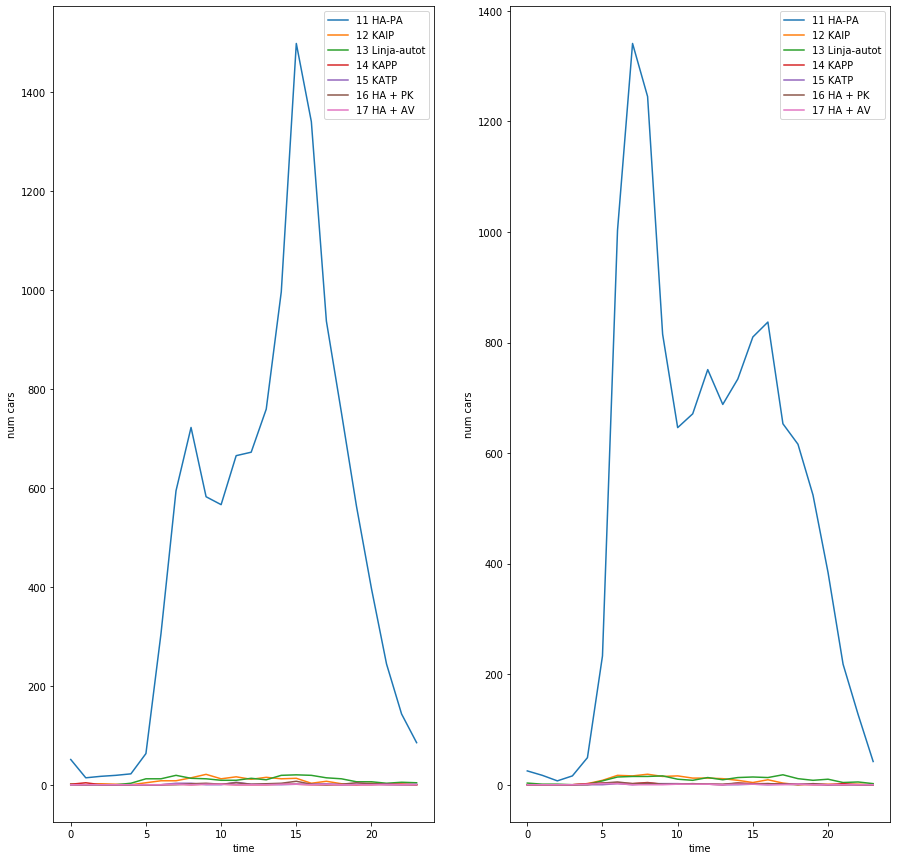

In [202]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,15))
ax1.set_xlabel('time')
ax1.set_ylabel('num cars')
ax2.set_xlabel('time')
ax2.set_ylabel('num cars')
for car_type in snapshot.Type.unique():
    d1 = snapshot[(snapshot.Type==car_type) & (snapshot.Direction==1)]
    d2 = snapshot[(snapshot.Type==car_type) & (snapshot.Direction==2)]
    values1 = d1.iloc[: , 5:]
    line1, = ax1.plot(range(0,24), values1.T)
    line1.set_label(car_type)
    values2 = d2.iloc[: , 5:]
    line2, = ax2.plot(range(0,24), values2.T)
    line2.set_label(car_type)
ax1.legend()
ax2.legend()